## Jaccard Distance Permutation Test

#### imports and loads

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import scipy.sparse
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib, mplcairo
import pickle
print('Default backend: ' + matplotlib.get_backend()) 
#matplotlib.use("module://mplcairo.macosx")
#print('Backend is now ' + matplotlib.get_backend())
sns.set()

path_root = "/Users/atanaltay/Documents/Research/inwork/marketing_emotions/codes/data/all_marketing_data/"
groupsAndCountsPath = path_root + "emoticon_analysis/tr_emoticon_groups_and_counts.csv"
emojisPath = path_root + "emoticon_analysis/emojis.csv"
path_in = path_root+ "tr_emoanalysis.parquet"
path_in_en= path_root + "en_emoanalysis.parquet"
#Existing emojis
groupsAndCountsDfEn = pd.read_csv(path_root + "emoticon_analysis/en_emoticon_groups_and_counts.csv")
groupsAndCountsDfTr = pd.read_csv(groupsAndCountsPath)
#Emoji codes
emojisdf = pd.read_csv(emojisPath)

cscPathTr = path_root + "emoticon_analysis/count_matrices/tr/csc_count.npz"
featuresPathTr = path_root + "emoticon_analysis/count_matrices/tr/feature_names.npy"

cscPathEn = path_root + "emoticon_analysis/count_matrices/en/csc_count.npz"
featuresPathEn = path_root + "emoticon_analysis/count_matrices/en/feature_names.npy"

cscCountsMatrixTr = scipy.sparse.load_npz(cscPathTr)
featureNamesArrayTr = np.load(featuresPathTr,allow_pickle=True)

cscCountsMatrixEn = scipy.sparse.load_npz(cscPathEn)
featureNamesArrayEn = np.load(featuresPathEn,allow_pickle=True)

dfTr = pd.read_parquet(path_in,columns=["id","created_at","company","type","industry","gender"])
dfEn = pd.read_parquet(path_in_en,columns=["id","created_at","company","type","industry","gender"])

Default backend: module://matplotlib_inline.backend_inline


#### Simulation

0.42352941176470593

0.49056603773584906

0.6451612903225806


In [3]:
def getJDistance(mtrxEnFromEn,mtrxEnFromTr, mtrxTrFromTr,mtrxTrFromEn,featureNamesTr,featureNamesEn):

    grpTr1 = pd.DataFrame(mtrxTrFromTr.sum(axis=0),columns=featureNamesArrayTr).T.reset_index().rename(columns={'index':'emoticon',0:'cnt'})
    grpTr2 = pd.DataFrame(mtrxTrFromEn.sum(axis=0),columns=featureNamesArrayEn).T.reset_index().rename(columns={'index':'emoticon',0:'cnt'})
    dfmergedTr = grpTr1.merge(grpTr2,how='outer',on='emoticon').groupby('emoticon')[['cnt_x','cnt_y']].sum()
    dfmergedTr['total']=dfmergedTr.cnt_x+dfmergedTr.cnt_y
    grpTr = dfmergedTr.sort_values(by='total',ascending=False).reset_index()
    
    
    grpEn1 = pd.DataFrame(mtrxEnFromTr.sum(axis=0),columns=featureNamesArrayTr).T.reset_index().rename(columns={'index':'emoticon',0:'cnt'})
    grpEn2 = pd.DataFrame(mtrxTrFromEn.sum(axis=0),columns=featureNamesArrayEn).T.reset_index().rename(columns={'index':'emoticon',0:'cnt'})
    dfmergedEn = grpEn1.merge(grpEn2,how='outer',on='emoticon').groupby('emoticon')[['cnt_x','cnt_y']].sum()
    dfmergedEn['total']=dfmergedEn.cnt_x+dfmergedEn.cnt_y
    grpEn = dfmergedEn.sort_values(by='total',ascending=False).reset_index()

    p1Tr = grpTr[grpTr.index<=200]
    p2Tr = grpTr[(grpTr.index>200) & (grpTr.index<=1000)]
    p3Tr = grpTr[grpTr.index>1000]

    #p0En = grpEn[grpEn.index<=100]
    #p1En = grpEn[(grpEn.index>100) & (grpEn.index<=200)]
    p1En = grpEn[grpEn.index<=200]
    p2En = grpEn[(grpEn.index>200) & (grpEn.index<=1000)]
    p3En = grpEn[grpEn.index>1000]
    
    jac_distP1 = 1-len(np.intersect1d(p1Tr.emoticon,p1En.emoticon))/len(np.union1d(p1Tr.emoticon,p1En.emoticon))
    jac_distP2=1-len(np.intersect1d(p2Tr.emoticon,p2En.emoticon))/len(np.union1d(p2Tr.emoticon,p2En.emoticon))
    jac_distP3=1-len(np.intersect1d(p3Tr.emoticon,p3En.emoticon))/len(np.union1d(p3Tr.emoticon,p3En.emoticon))

    return [jac_distP1,jac_distP2,jac_distP3]




In [24]:


dfTr['period']= pd.to_datetime(dfTr.created_at).dt.to_period('M')
dfEn['period']= pd.to_datetime(dfEn.created_at).dt.to_period('M')

grpDataTr = dfTr.groupby(by='period')
grpDataEn = dfEn.groupby(by='period')




/Users/atanaltay/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1146: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


In [20]:
grpDataEn.sample(frac=0.5).groupby(by='period')

In [26]:



#sample tr: 500.000
#sample en: 2000.000

maxRun = 1000

sizeTotal = 150000
propTr = 0.1
propEn = 0.9

results = []
ys=[]

for i in range(maxRun):
    print("run:",i,"\n\r")
    results_run = []
    y_run=[]

    grpDataTr = dfTr.sample(int(sizeTotal/2)).groupby(by='period')
    grpDataEn = dfEn.sample(int(sizeTotal/2)).groupby(by='period')



    for group in grpDataTr:
        indicesTr = grpDataTr.get_group(group[0])
        indicesEn = grpDataEn.get_group(group[0])
        indicesTr = indicesTr.sample(int(sizeTotal/2),replace=True)
        indicesEn = indicesEn.sample(int(sizeTotal/2),replace=True)
        
        sampleFromTr = cscCountsMatrixTr[indicesTr.index,:]
        sampleFromEn = cscCountsMatrixEn[indicesEn.index,:]

        idxFromTr2 = np.random.randint(0,sampleFromTr.shape[0],size=int(sampleFromTr.shape[0]*propTr))
        idxFromEn2 = np.random.randint(0,sampleFromEn.shape[0],size=int(sampleFromEn.shape[0]*propTr))

        sampleFromTrforTr = sampleFromTr[idxFromTr2]
        sampleFromEnforTr = sampleFromEn[idxFromEn2]


        idxFromTr3 = np.random.randint(0,sampleFromTr.shape[0],size=int(sampleFromTr.shape[0]*propEn))
        idxFromEn3 = np.random.randint(0,sampleFromEn.shape[0],size=int(sampleFromEn.shape[0]*propEn))

        sampleFromTrforEn = sampleFromTr[idxFromTr3]
        sampleFromEnforEn = sampleFromEn[idxFromEn3]

        stat1 = getJDistance(mtrxEnFromEn=sampleFromEnforEn,mtrxEnFromTr=sampleFromTrforEn ,mtrxTrFromEn=sampleFromEnforTr,mtrxTrFromTr=sampleFromTrforTr,featureNamesEn=featureNamesArrayEn,featureNamesTr=featureNamesArrayTr)
        results_run.append(stat1)
        y_run.append(pd.to_datetime(group[0].strftime('%Y-%m-%d')))
    
    results.append(results_run)
    ys.append(y_run)


run: 0 

run: 1 



KeyboardInterrupt: 

#### Reports

In [10]:
results = np.array(results)

/Users/atanaltay/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


In [13]:
results[0].shape

AttributeError: 'list' object has no attribute 'shape'

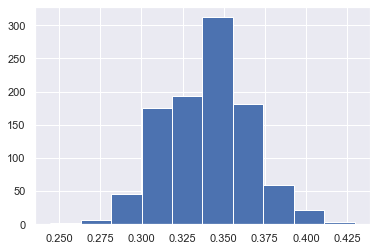

In [69]:
plt.hist(results[:,0])
plt.show()

In [70]:
#resultsEn = resultsEn[~np.isnan(resultsEn).any(axis=0)]
#resultsEn = np.array(resultsEn)
high_pop = results[:,0]

pval=  high_pop[high_pop>0.42].shape[0] /high_pop.shape[0]
print(pval)

0.002


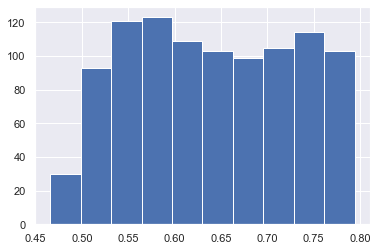

In [71]:
plt.hist(results[:,1])
plt.show()

In [72]:
med_pop = results[:,1]

pval=  med_pop[med_pop<0.49].shape[0] /med_pop.shape[0]
print(pval)

0.014


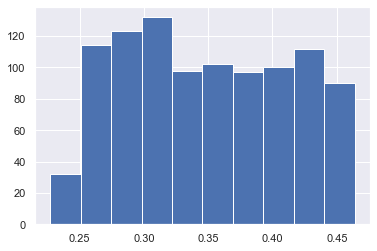

In [73]:
plt.hist(results[:,2])
plt.show()

In [77]:
low_pop = results[:,2]

pval=  low_pop[low_pop>0.65].shape[0] /low_pop.shape[0]
print(pval)

0.0
